## Simple H2O AutoML Baseline:

* Add original data
* Add location with reverse geocoder
* Run AutoML


In [1]:
import pandas as pd
import h2o        
from h2o.automl import H2OAutoML
from sklearn.datasets import fetch_california_housing

In [2]:
path = "/kaggle/input/playground-series-s3e1/"
train_df = pd.read_csv(path+"train.csv")
test_df = pd.read_csv(path+"test.csv")
sub = pd.read_csv(path+"sample_submission.csv")

### Data preparation

In [3]:
external_data = fetch_california_housing()
train2 = pd.DataFrame(external_data['data'])
train2['target'] = external_data['target']
train2.columns = train_df.columns[1:]
train_df = pd.concat([train_df,train2]).drop_duplicates()

In [4]:
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=f1deed62f4f052c1ffaa436d631379d2ef4e9f199d3742a4f25ed1b1ec91857b
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse_geocoder


In [5]:
import reverse_geocoder as rg

for df in [train_df,test_df]:
    coordinates = list(zip(df['Latitude'], df['Longitude']))
    results = rg.search(coordinates)
    df['county'] = [x['admin2'] for x in results]
    df['place'] = [x['name'] for x in results]

Loading formatted geocoded file...


### Auto ML

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbob0jwiq
  JVM stdout: /tmp/tmpbob0jwiq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbob0jwiq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_unknownUser_fyczla
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [7]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
target = 'MedHouseVal'
features = train_df.columns.drop([target,'id','Population']).to_list()

aml = H2OAutoML(max_runtime_secs=5000, seed=11,nfolds=10)
aml.train(x=features, y=target, training_frame=train_h2o);

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [9]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20230107_121830,0.515676,0.265922,0.35146,0.154283,0.265922
StackedEnsemble_AllModels_4_AutoML_1_20230107_121830,0.515692,0.265939,0.351465,0.154282,0.265939
StackedEnsemble_BestOfFamily_4_AutoML_1_20230107_121830,0.517515,0.267822,0.35315,0.154899,0.267822
StackedEnsemble_BestOfFamily_5_AutoML_1_20230107_121830,0.517825,0.268142,0.354593,0.154907,0.268142
StackedEnsemble_AllModels_2_AutoML_1_20230107_121830,0.519649,0.270035,0.353981,0.155285,0.270035
StackedEnsemble_AllModels_1_AutoML_1_20230107_121830,0.519722,0.270111,0.354096,0.155322,0.270111
StackedEnsemble_BestOfFamily_3_AutoML_1_20230107_121830,0.521552,0.272017,0.355132,0.155727,0.272017
StackedEnsemble_BestOfFamily_2_AutoML_1_20230107_121830,0.521619,0.272086,0.355429,0.155745,0.272086
StackedEnsemble_BestOfFamily_1_AutoML_1_20230107_121830,0.52334,0.273885,0.357242,0.156372,0.273885
GBM_grid_1_AutoML_1_20230107_121830_model_21,0.524782,0.275396,0.359655,0.157262,0.275396


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

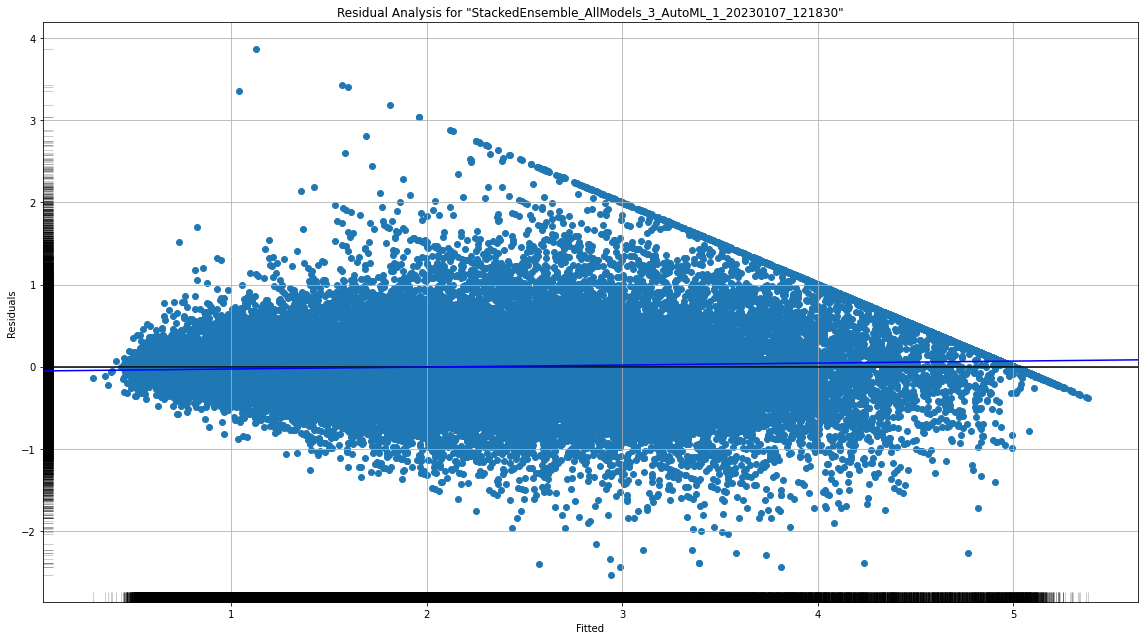

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

In [10]:
aml.leader.explain(train_h2o,include_explanations=['residual_analysis'])

### Submission

In [11]:
sub[target] = aml.leader.predict(test_h2o).as_data_frame()
sub.to_csv("submission.csv", index=False)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'county' has levels not trained on: ["Esmeralda County"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'place' has levels not trained on: ["Goldfield", "Yerington"]
  warnings.warn(w)


In [12]:
sub.describe()

,id,MedHouseVal
count,24759.000000,24759.000000
mean,49516.000000,2.077457
std,7147.451994,1.027160
min,37137.000000,0.450628
25%,43326.500000,1.305528
50%,49516.000000,1.887982
75%,55705.500000,2.651156
max,61895.000000,5.264547


In [13]:
sub.head()

,id,MedHouseVal
0,37137,0.710616
1,37138,1.051312
2,37139,4.354939
3,37140,3.311152
4,37141,2.537045
